## Packages 

In [19]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [20]:
# import packages
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf

import descarteslabs as dl
import descarteslabs.workflows as wf
import utils_santo 
import importlib
import tifffile

from utils_santo import gdal_dataset_from_geocontext
from unet import UNet
from PIL import Image
from shapely.geometry import shape
from osgeo import gdal, ogr
from typing import Sequence

## Import GeoJSON

In [21]:
with open("polygons/parry_town.geojson") as f:
    fc = json.load(f)

In [22]:
a_map = wf.interactive.MapApp()
a_map.center = (18.394, -77.093)
a_map.zoom = 15

los_plat_geojson = ipyleaflet.GeoJSON(data=fc,
                   style={"color": "red", "fillOpacity": 0.1},
                   hover_style={"fillOpacity": 0.1})

a_map.add_layer(los_plat_geojson)

img = wf.ImageCollection.from_id("sentinel-2:L1C",start_datetime='2017-08-1', end_datetime='2020-09-9').pick_bands("red green blue cloud-mask") #North santo-domingo: start_datetime='2020-11-24', end_datetime='2020-12-01' #Parry town: start_datetime='2017-08-1', end_datetime='2020-09-9'
img = img.filter(lambda img:img.properties["cloud_fraction"] <= 0.01)
img = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1))

my_mosaic = img.pick_bands("red green blue").mosaic()
my_mosaic.visualize('image', scales=[(0, 1), (0, 1), (0, 1)], map=a_map)

a_map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## Generate Training Data from Polygons

In [26]:
def generate_tiff_from_polygons(
    polygons, #Should be saved as a FeatureCollection in earth engine
    products,
    bands,
    resolution,
    tilesize,
    pad,
    cloud_fraction,
    start_datetime,
    end_datetime,
    out_folder,
    seed=0,
    debugging = False,
    manual_aoi_poly = None #Should be saved as a FeatureCollection in earth engine
    ):
    
    if isinstance(polygons, str):
        fname = polygons
        with open(fname) as f:
            poly = json.load(f)
        polygons = {"type": "FeatureCollection", "features": poly["features"]}
        ogr_ds = ogr.Open(fname)
    elif isinstance(polygons, dict):
        assert polygons["type"] == "FeatureCollection"
        ogr_ds = ogr.Open(json.dumps(polygons))
    else:
        print("Wrong datatype for POLYGONS.")
        return 0
    n_features = len(polygons["features"])
    layer = ogr_ds.GetLayer()
    
    
    
    if isinstance(manual_aoi_poly, str):
        with open(manual_aoi_poly) as f:
            aoi_poly_collection = json.load(f)
        aoi_poly = aoi_poly_collection["features"][0]["geometry"]
    elif isinstance(manual_aoi_poly, dict):
        assert manual_aoi_poly["type"] == "FeatureCollection"
        aoi_poly = manual_aoi_poly
    elif manual_aoi_poly is None:
        #Bounding box covering all the polygons
        poly_coords = []
        for i in range(n_features):
            poly_coords.extend(polygons['features'][i]['geometry']['coordinates'][0])


        min_corner = [min(map(lambda x:x[0], poly_coords)), min(map(lambda x:x[1], poly_coords))]
        max_corner = [max(map(lambda x:x[0], poly_coords)), max(map(lambda x:x[1], poly_coords))]

        #Turn this into a polygon
        aoi_poly = {
            "type":"Polygon",
            "coordinates":[[
                min_corner,
                [min_corner[0], max_corner[1]],
                max_corner,
                [max_corner[0], min_corner[1]],
                min_corner
            ]]
        } 
    else:
        print("Wrong datatype for MANUAL_AOI")

        
        
    #Get dltiles for bounding box around geojsons
    dltiles = dl.scenes.DLTile.from_shape(shape = aoi_poly, resolution = resolution, tilesize = tilesize, pad = pad)
    
    arrs = []
    trgts = []
    
    #Normalisation for spectral bands for the given product. ASSUMES THEY ARE ALL ON THE SAME SCALE
    product_bands = list(dl.catalog.Product.get(products).bands())
    
    max_spectral_val = -1
    for band in product_bands:
        if band.type == 'spectral':
            max_spectral_val = band.data_range[1]
            break
    
    if max_spectral_val == -1:
        print("Could not find maximum spectral value for bands in product")
        return
    
    if not os.path.exists(out_folder + "sentinel_raster_maps/"):
        os.makedirs(out_folder + "sentinel_raster_maps/")
    if not os.path.exists(out_folder + "target_raster_maps/"):
        os.makedirs(out_folder + "target_raster_maps/")
    
    for i, dltile in enumerate(dltiles):
        savefile_image = out_folder + "sentinel_raster_maps/" + "{}.tiff".format("image_"+str(i))
        savefile_target = out_folder + "target_raster_maps/" "{}.tiff".format("target_"+str(i))
        
        # Search for scenes for the dltile
        scenes, ctx = dl.scenes.search(
            aoi=dltile,
            products=products,
            cloud_fraction=cloud_fraction,
            start_datetime=start_datetime,
            end_datetime=end_datetime,
        )
        
        #Break if no valid scene for this dltile
        if len(scenes) == 0:
            break
            
        #Get the raster image for these scenes - i.e the satellite data in the given bands
        arr = scenes.mosaic(bands=bands, ctx=ctx, bands_axis=-1) #* 255 / max_spectral_val
        #n.b you can plot this using plt.imshow(arr.data)
        arr = np.ma.MaskedArray.astype(np.rint(arr/max_spectral_val * 255), np.uint8)
        tifffile.imsave(savefile_image, arr, planarconfig="contig")
        #image = Image.fromarray(arr)
        #image.save(savefile_image)
        
        # Using the metadata get the target - the map of whether the settlements are informal or not
        ds_target = gdal_dataset_from_geocontext(
            ctx,
            1,
            driver_name="GTiff",
            savename=savefile_target,
            dtype="byte",
            options=["COMPRESS=LZW"],
        )
        
        gdal.RasterizeLayer(
            ds_target,
            [1],
            layer,
            burn_values=[1],
            options=["ALL_TOUCHED=TRUE", "COMPRESS=LZW"],
        )

        del ds_target

        
        
        if debugging:
            arrs.append(arr)
            img_target = np.array(Image.open(savefile_target))
            trgts.append(img_target)
            #Again can be viewed with plt.imshow(img_target)
        
 
        

    if debugging: 
        return arrs, trgts
    else:
        return

In [31]:
tilesize=64

generate_tiff_from_polygons("polygons/parry_town.geojson",
                products='sentinel-2:L1C',
                bands=['red', 'green', 'blue', 'red-edge', 'red-edge-2', 'red-edge-3', 'red-edge-4', 'nir', 'swir1', 'swir2'],
                resolution=10,
                tilesize=tilesize,
                pad=0,
                cloud_fraction = 0.01,
                start_datetime='2017-08-1',
                end_datetime='2020-09-9',
                out_folder='parry_town_large_aoi_{}/'.format(tilesize),
                manual_aoi_poly="polygons/parry_town_aoi.geojson",
                )

## How to load and show a target/image .tiff files

In [78]:
data_folder = "parry_town_large_aoi_{}/".format(tilesize)

no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(data_folder + "sentinel_raster_maps/"))))
img_iterator = iter(range(no_images))

Run the cell below repeatedly to go through all the corresponding image/targets in the data folder

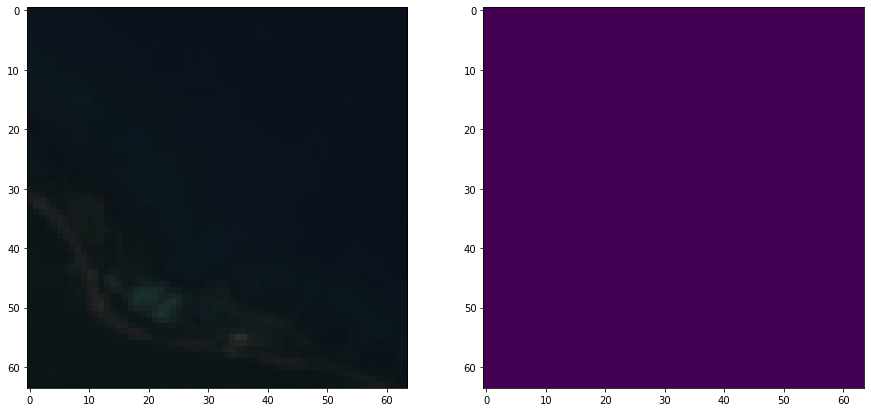

In [88]:
fig, ax = plt.subplots(1,2, figsize = (15,15))

i = next(img_iterator)

a_target = Image.open('{}/target_{}.tiff'.format(data_folder+"target_raster_maps", i)) #tifffile complains about codecs if you try to use that here
target_pixel_data = np.reshape(list(a_target.getdata()), (64,64))
ax[1].imshow(target_pixel_data)

a_image = tifffile.imread("{}/image_{}.tiff".format(data_folder+"sentinel_raster_maps", i))
image_pixel_data = a_image[:,:,0:3] #RGB Selected as bands 1:3
ax[0].imshow(image_pixel_data)